In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from pydataset import data
from math import sqrt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
#from sklearn.tree import export_graphviz
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import acquire
import env
import explore
import prepare

import graphviz
from graphviz import Graph

In [2]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})

Project Objectives

Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook report.

Create modules (acquire.py, prepare.py) that make your process repeateable.

Construct a model to predict customer churn using classification techniques.

In [3]:
#acquire the data

df = pd.read_sql('''SELECT *
FROM customers
JOIN contract_types USING(contract_type_id)
JOIN internet_service_types USING(internet_service_type_id)
JOIN payment_types USING(payment_type_id);''', acquire.get_connection("telco_churn"))

In [4]:
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [5]:
#complete some initial summarization

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [7]:
df.value_counts()

payment_type_id  internet_service_type_id  contract_type_id  customer_id  gender  senior_citizen  partner  dependents  tenure  phone_service  multiple_lines  online_security      online_backup        device_protection    tech_support         streaming_tv         streaming_movies     paperless_billing  monthly_charges  total_charges  churn  contract_type   internet_service_type  payment_type             
1                1                         1                 0015-UOCOJ   Female  1               No       No          7       Yes            No              Yes                  No                   No                   No                   No                   No                   Yes                48.20            340.35         No     Month-to-month  DSL                    Electronic check             1
3                2                         1                 4361-BKAXE   Female  0               No       No          41      Yes            Yes             Yes                  Ye

In [8]:
################################################################ PREPARE

In [9]:
#investigate the data from all angles and prepare
df.shape

(7043, 24)

In [10]:
print(df.churn.value_counts())

No     5174
Yes    1869
Name: churn, dtype: int64


In [11]:
df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


**What are some possible drivers of churn?**

Hypothesis 1: Let's see if there is a relationship between payment type and churn.
$H_0$: There is no relationship between payment type and churn, they are independent. 
$H_a$: There is a relationship between payment type and churn, they are dependent on each other. 
Outcome: I rejected the Null Hypothesis; there is a relationship between payment type and churn.

Hypothesis 2: Let's see if there is a relationship between being a senior citizen and churn.
alpha = .05
$H_0$: There is no relationship between being a senior citizen or not and churn, they are independent. 
$H_a$: There is a relationship between beinga a senior citizen or not and churn, they are dependent on each other.

Hypothesis 3 - Let's see if there is a relationship between monthly_charges and churn.
alpha = .05
$H_0$: There is no relationship and churn is independent of monthly_charges amount.
$H_a$: There is a relationship churn is dependent on monthly_charges amount.

Hypothesis 4 - Let's see if churn is effected by tenure.
alpha = .05
$H_0$: Those with a higher tenure are just as likely to churn as those with a lower tenure.
$H_a$: Those with a higher tenure are less likely to churn than those with a lower tenure

Hypothesis 5 Internet service type effects churn rate
alpha = .05
$H_0$: Internet service type is independent of churn.
$H_a$: Churn is dependent on internet service type.

In [12]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [14]:
#drop columns with id since I used those just to JOIN the data
df.drop(columns=['payment_type_id','internet_service_type_id', 'contract_type_id'],inplace=True)

In [15]:
#make sure they are gone
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [16]:
#make target column binary
df.churn.replace(to_replace=['yes','no'],value=[1,0], inplace=True)

In [17]:
#check to see that the target is binary
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [18]:
#drop all additional services since I am not interested in exploring
df.drop(columns=['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies','paperless_billing'],inplace=True)

In [19]:
#make sure they are actually gone
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [20]:
#check for missing values in the total_charges column
df.total_charges.str.contains('')

0       True
1       True
2       True
3       True
4       True
        ... 
7038    True
7039    True
7040    True
7041    True
7042    True
Name: total_charges, Length: 7043, dtype: bool

In [21]:
#find any missing values
df.total_charges.value_counts()

20.2       11
           11
19.75       9
20.05       8
19.9        8
           ..
42.7        1
2193.2      1
3091.75     1
3139.8      1
1423.05     1
Name: total_charges, Length: 6531, dtype: int64

In [22]:
#this shows me each row where the total_charges column have a missing vlaue
df[df['total_charges'].str.contains(' ')]

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
85,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,56.05,,No,Two year,DSL,Credit card (automatic)
156,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,61.90,,No,Two year,DSL,Bank transfer (automatic)
236,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,73.35,,No,Two year,DSL,Mailed check
255,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,52.55,,No,Two year,DSL,Bank transfer (automatic)
339,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,80.85,,No,Two year,DSL,Mailed check
5681,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,20.00,,No,Two year,None,Mailed check
5717,3115-CZMZD,Male,0,No,Yes,0,Yes,No,20.25,,No,Two year,None,Mailed check
5727,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,25.35,,No,Two year,None,Mailed check
5798,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,25.75,,No,Two year,None,Mailed check
6007,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,19.85,,No,Two year,None,Mailed check


In [23]:
# this will get rid of the rows with no value in the total_charges column
df.drop(df[df['total_charges'].str.contains(" ")].index, inplace = True)

In [24]:
# now I am checking that the missing values don't exist anymore
df.total_charges.value_counts()

20.2       11
19.75       9
20.05       8
19.65       8
19.9        8
           ..
2193.2      1
3091.75     1
3139.8      1
7303.05     1
1423.05     1
Name: total_charges, Length: 6530, dtype: int64

In [25]:
# Drop duplicatesreassign and check the shape of my data.

df = df.drop_duplicates()
df.shape

(7032, 14)

In [26]:
#pd.to_numeric(df[column])
df['total_charges'] = pd.to_numeric(df['total_charges'])

In [27]:
#split the dataset
#prepare.prep_telco(df)

In [28]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [29]:
train, validate, test = train_validate_test_split(df, target='churn')
train.head(2)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6096,8966-SNIZF,Female,0,Yes,No,70,Yes,No,19.45,1303.5,No,Two year,None,Bank transfer (automatic)
1603,3466-BYAVD,Male,0,Yes,Yes,15,Yes,No,69.50,1071.4,No,Month-to-month,DSL,Mailed check


In [30]:
############################################################ EXPLORE

In [31]:
#create a heatmap contract_type and churn
pd.crosstab(train.contract_type, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,No,Yes,All
contract_type,,,
Month-to-month,1209,926,2135
One year,744,86,830
Two year,938,34,972
All,2891,1046,3937


In [32]:
#create a heatmap internet_service_type and churn
pd.crosstab(train.internet_service_type, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,No,Yes,All
internet_service_type,,,
DSL,1102,266,1368
Fiber optic,982,716,1698
None,807,64,871
All,2891,1046,3937


In [33]:
#create a heatmap payment_type and churn
pd.crosstab(train.payment_type, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,No,Yes,All
payment_type,,,
Bank transfer (automatic),719,170,889
Credit card (automatic),712,122,834
Electronic check,723,588,1311
Mailed check,737,166,903
All,2891,1046,3937


In [34]:
#create a heatmap senior_citizen and churn
pd.crosstab(train.senior_citizen, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,No,Yes,All
senior_citizen,,,
0,2524,766,3290
1,367,280,647
All,2891,1046,3937


**Takeaways from heatmaps**
-month-to-month customers churn the most of contract_type approximately 43%
-Fiber optics has the highest rate of churn at 43% churning of this internet_service_type
-Electronic check has the highest churn rate at 46%
-senior_citizens churn at a much higher rate than other customers 44% compared to 23% for overall customers

In [35]:
cat_vars = ['churn', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service_type', 'phone_service','multiple_lines','contract_type']
quant_vars = ['monthly_charges', 'total_charges','tenure']

In [36]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,90.45,5957.90,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,45.05,2560.10,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,39.40,825.40,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,85.15,6316.20,No,Two year,DSL,Bank transfer (automatic)


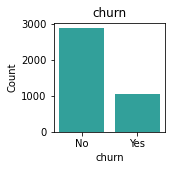

    churn  Count  Percent
No     No   2891    73.43
Yes   Yes   1046    26.57
_________________________________________________________________


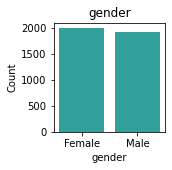

        gender  Count  Percent
Male    Female   2002    50.85
Female    Male   1935    49.15
_________________________________________________________________


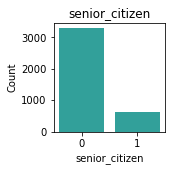

   senior_citizen  Count  Percent
0               0   3290    83.57
1               1    647    16.43
_________________________________________________________________


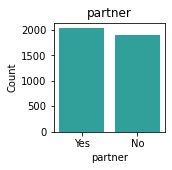

    partner  Count  Percent
No      Yes   2033    51.64
Yes      No   1904    48.36
_________________________________________________________________


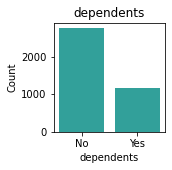

    dependents  Count  Percent
No          No   2764    70.21
Yes        Yes   1173    29.79
_________________________________________________________________


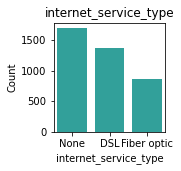

            internet_service_type  Count  Percent
Fiber optic                  None   1698    43.13
DSL                           DSL   1368    34.75
None                  Fiber optic    871    22.12
_________________________________________________________________


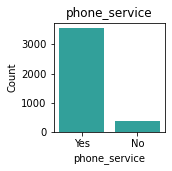

    phone_service  Count  Percent
Yes           Yes   3548    90.12
No             No    389     9.88
_________________________________________________________________


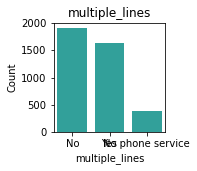

                    multiple_lines  Count  Percent
No                              No   1906    48.41
Yes                            Yes   1642    41.71
No phone service  No phone service    389     9.88
_________________________________________________________________


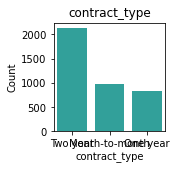

                 contract_type  Count  Percent
Month-to-month        Two year   2135    54.23
Two year        Month-to-month    972    24.69
One year              One year    830    21.08
_________________________________________________________________


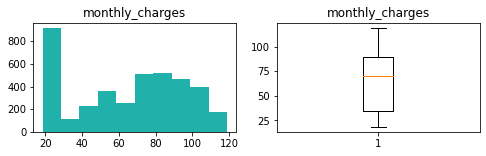

count    3937.000000
mean       64.191046
std        30.129425
min        18.550000
25%        34.950000
50%        69.950000
75%        89.450000
max       118.750000
Name: monthly_charges, dtype: float64


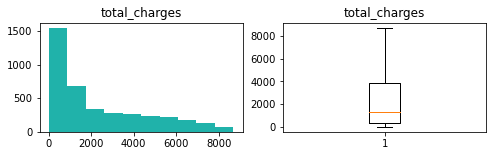

count    3937.000000
mean     2281.487668
std      2287.371123
min        18.800000
25%       371.400000
50%      1359.700000
75%      3827.900000
max      8684.800000
Name: total_charges, dtype: float64


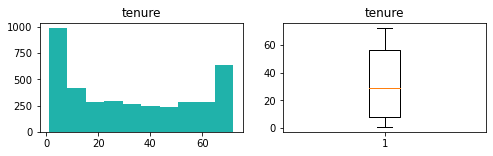

count    3937.000000
mean       32.505715
std        24.773712
min         1.000000
25%         8.000000
50%        29.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64


In [37]:
explore.explore_univariate(train, cat_vars, quant_vars)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba52b2a790>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba52b2ae80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba513b09a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba52917580>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba529178e0>],
 'means': []}

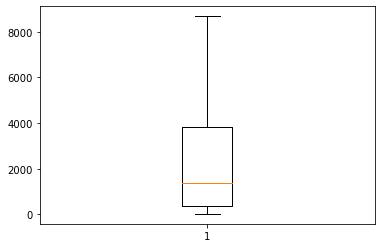

In [38]:
plt.boxplot(train.total_charges)

In [39]:
train.dtypes

customer_id               object
gender                    object
senior_citizen             int64
partner                   object
dependents                object
tenure                     int64
phone_service             object
multiple_lines            object
monthly_charges          float64
total_charges            float64
churn                     object
contract_type             object
internet_service_type     object
payment_type              object
dtype: object

In [40]:
cat_vars = ['senior_citizen']

In [41]:
quant_vars = ['monthly_charge','tenure','total_charges']

In [42]:
#change churn to 0 or 1
#explore.explore_bivariate(train, 'churn', cat_vars, quant_vars)
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6096,8966-SNIZF,Female,0,Yes,No,70,Yes,No,19.45,1303.50,No,Two year,None,Bank transfer (automatic)
1603,3466-BYAVD,Male,0,Yes,Yes,15,Yes,No,69.50,1071.40,No,Month-to-month,DSL,Mailed check
5350,9278-VZKCD,Female,1,Yes,No,52,Yes,Yes,109.10,5647.95,No,Month-to-month,Fiber optic,Electronic check
2068,7074-STDCN,Male,0,No,No,39,No,No phone service,40.60,1494.50,No,Month-to-month,DSL,Electronic check
6366,5914-GXMDA,Female,0,Yes,No,32,Yes,No,19.30,593.20,No,One year,None,Mailed check


In [43]:
def explore_multivariate(train, churn, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, churn, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, churn, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue=churn)
    plt.show()
    plot_all_continuous_vars(train, churn, quant_vars)
    plt.show()    

In [44]:
target = 'churn'

In [45]:
#explore.explore_multivariate(train, 'churn', cat_vars, quant_vars)

**Descriptive stats, frequencies, histograms Takeaways**

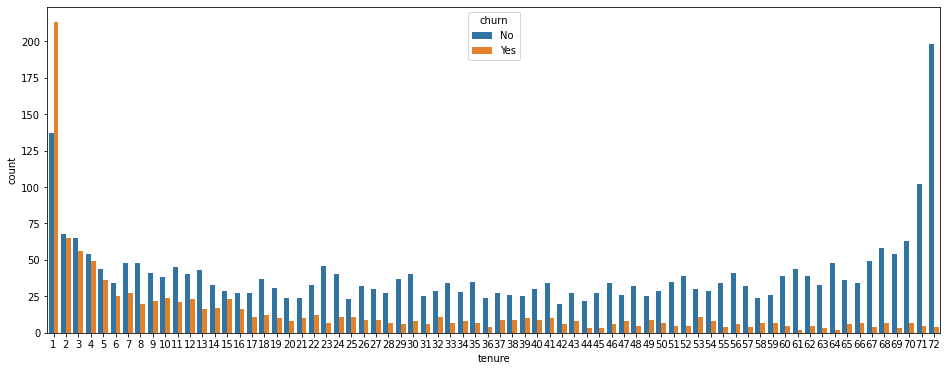

In [46]:
plt.figure(figsize=(16, 6)) # changes the size of the figure
sns.countplot(data=train, x='tenure', hue='churn')
plt.show()

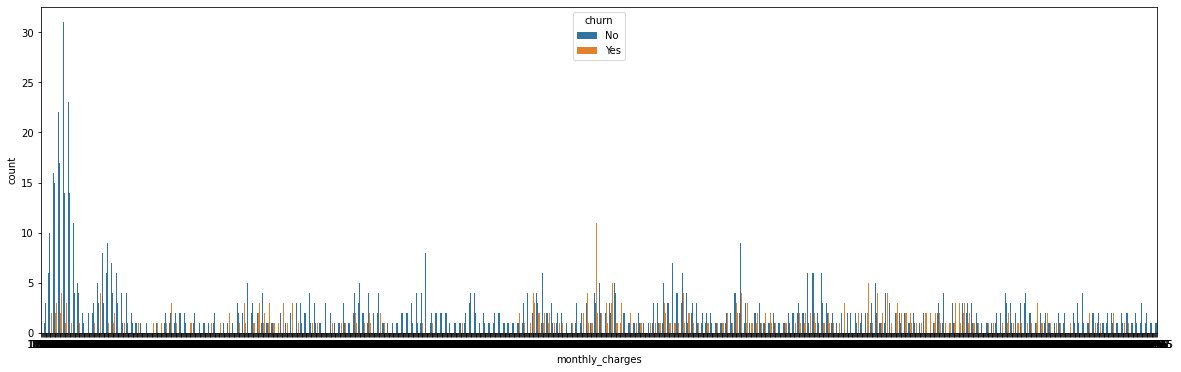

In [47]:
# plot monthly_charges by churn
plt.figure(figsize=(20, 6))
sns.countplot(data=train, x='monthly_charges', hue='churn')
plt.show()

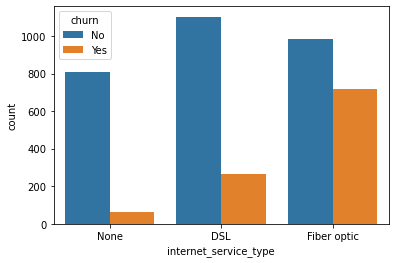

In [48]:
# plot internet_service_type by churn
sns.countplot(data=train, x='internet_service_type', hue='churn')
plt.show()

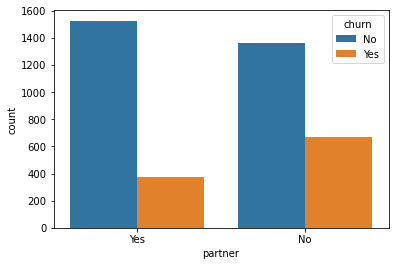

In [49]:
# plot with or without partner by churn
sns.countplot(data=train, x='partner',hue='churn')
plt.show()

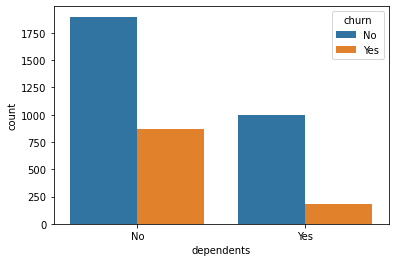

In [50]:
# plot with or without dependents by churn
sns.countplot(data=train, x='dependents', hue='churn')
plt.show()

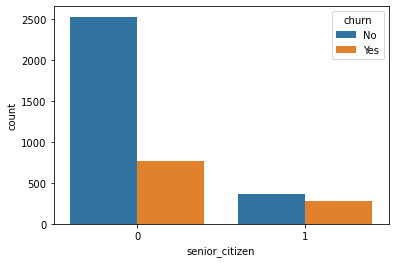

In [51]:
# plot senior_citizen by churn
sns.countplot(data=train, x='senior_citizen', hue='churn')
plt.show()

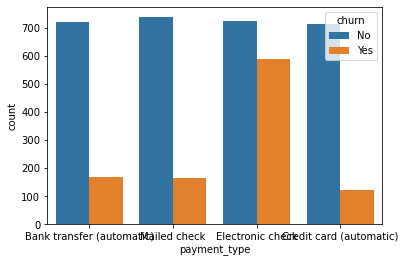

In [52]:
# plot payment_type by churn
sns.countplot(data=train, x='payment_type', hue='churn')
plt.show()

**Countplot Takeaways**
-tenure is by far highest at one month and by far least at 72 months
-customers with the lowest monthly bills are churning the most
-fiber optics service type churns at a rate by far higher than the other two
-those customers without partners churn at a much higher rate
-customers with dependents churn at a slightly higher rate
-seniors churn at a much higher rate than other customers
-customers who pay with electronic check churn near as much as all the other 3 payment types combined

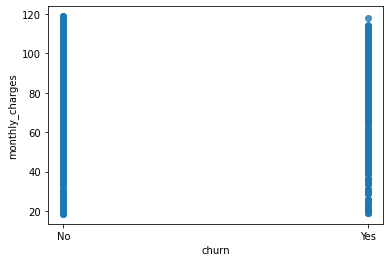

In [53]:
#let's look at some more visualizations
A = sns.regplot(x=train['churn'], y=train['monthly_charges'], fit_reg=False)

<AxesSubplot:xlabel='churn', ylabel='tenure'>

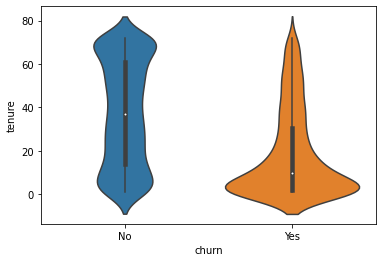

In [54]:
sns.violinplot(x=train["churn"], y=train["tenure"])

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

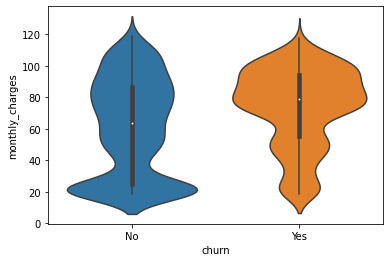

In [55]:
sns.violinplot(x=train["churn"], y=train["monthly_charges"])

**Violinplot takeaways**
-churn is much higher at the lowesst tenure
-churn is higher for customers with higher monthly charges

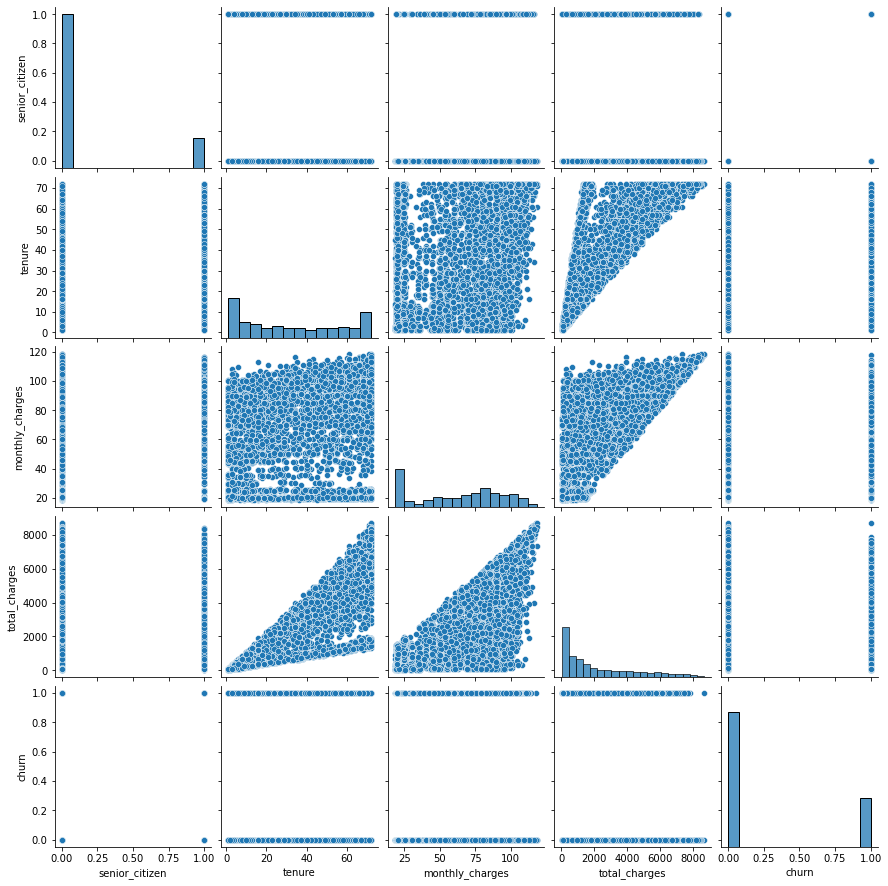

In [154]:
# make a correlogram
sns.pairplot(train)


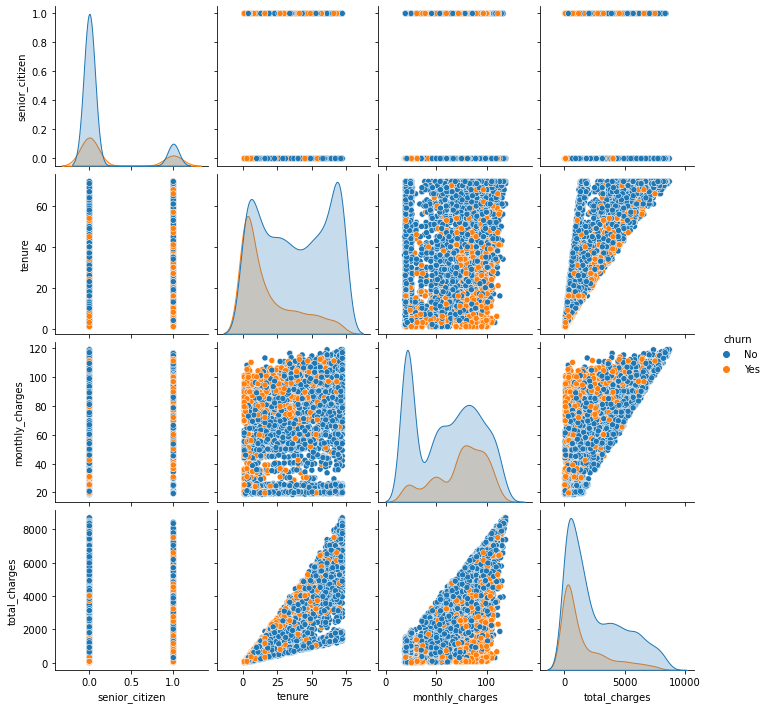

In [57]:
sns.pairplot(train, hue='churn')
plt.show()

**Takeaway from pairplot**
-customers churn more often at the lower tenures
-customers churn the lesast with high monthly bills and high tenure
-senior citizens with all types of tenure churn at a similar rate unlike the rest of the population that mostly churns at a lower tenure

In [58]:
#####################################################Statistical Testing

Hypothesis 1: Let's see if there is a relationship between payment type and churn.
$H_0$: There is no relationship between payment type and churn, they are independent. 
$H_a$: There is a relationship between payment type and churn, they are dependent on each other. 

Hypothesis 2: Let's see if there is a relationship between being a senior citizen and churn.
alpha = .05
$H_0$: There is no relationship between being a senior citizen or not and churn, they are independent. 
$H_a$: There is a relationship between beinga a senior citizen or not and churn, they are dependent on each other.

In [59]:
#y_train   #yes and no series
#X_train    #everything 0 or 1
#y_validate  # 0 or 1
#X_validate   # 0 or 1

In [155]:
y_train.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

In [201]:
y_train

6096    0
1603    0
5350    0
2068    0
6366    0
       ..
296     0
4200    1
3012    0
763     0
3935    0
Name: churn, Length: 3937, dtype: int64

In [61]:
train.churn.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

In [62]:
validate.churn.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

In [63]:
test.churn.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

In [64]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6096,8966-SNIZF,Female,0,Yes,No,70,Yes,No,19.45,1303.50,0,Two year,None,Bank transfer (automatic)
1603,3466-BYAVD,Male,0,Yes,Yes,15,Yes,No,69.50,1071.40,0,Month-to-month,DSL,Mailed check
5350,9278-VZKCD,Female,1,Yes,No,52,Yes,Yes,109.10,5647.95,0,Month-to-month,Fiber optic,Electronic check
2068,7074-STDCN,Male,0,No,No,39,No,No phone service,40.60,1494.50,0,Month-to-month,DSL,Electronic check
6366,5914-GXMDA,Female,0,Yes,No,32,Yes,No,19.30,593.20,0,One year,None,Mailed check


In [131]:
# calculate baseline_accuracy
baseline_accuracy=(train.churn == 0).mean()
round(baseline_accuracy,2) 

0.73

In [ ]:
# make dummy variable for senior_citizen and payment_type

dummy_df = pd.get_dummies(df[['senior_citizen','payment_type']])
dummy_df.head()

In [ ]:
# concatenate the dummy_df dataframe above with the original df 

df = pd.concat([df, dummy_df], axis=1)
df.head(1)

In [ ]:
# test hypothesis 1

In [ ]:
#set alpha to .05
a = .05

In [ ]:
observed = pd.crosstab(train.churn, train.payment_type)
observed

In [ ]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

In [ ]:
if p < a:
    print("Reject null hypothesis, payment type and churn are not independent")
else:
    print("Fail to reject null hypothesis, payment type and churn are independent, let's keep finding features that are not.")

In [68]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6096,8966-SNIZF,Female,0,Yes,No,70,Yes,No,19.45,1303.50,0,Two year,None,Bank transfer (automatic)
1603,3466-BYAVD,Male,0,Yes,Yes,15,Yes,No,69.50,1071.40,0,Month-to-month,DSL,Mailed check
5350,9278-VZKCD,Female,1,Yes,No,52,Yes,Yes,109.10,5647.95,0,Month-to-month,Fiber optic,Electronic check
2068,7074-STDCN,Male,0,No,No,39,No,No phone service,40.60,1494.50,0,Month-to-month,DSL,Electronic check
6366,5914-GXMDA,Female,0,Yes,No,32,Yes,No,19.30,593.20,0,One year,None,Mailed check


In [69]:
#copy the train dataset
train_encoded = train.copy()

In [70]:
encoded_columns = ['gender','contract_type','partner','dependents','phone_service','multiple_lines','internet_service_type','payment_type']

In [71]:
#make dummy variables
dummy_df = pd.get_dummies(train_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

In [72]:
# put it all back together
train_encoded = pd.concat([train_encoded, dummy_df], axis=1)

In [73]:
# drop initial column since we have that information now
train_encoded = train_encoded.drop(columns=encoded_columns)

In [74]:
# do the same for validate and test sets

In [75]:
# copy the validate dataset
validate_encoded = validate.copy()

In [76]:
#make dummy variables
dummy_df = pd.get_dummies(validate_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

In [77]:
# put it all back together
validate_encoded = pd.concat([validate_encoded, dummy_df], axis=1)

In [78]:
# drop initial column since we have that information now
validate_encoded = validate_encoded.drop(columns=encoded_columns)

In [79]:
# copy the test dataset
test_encoded = test.copy()

In [80]:
#make dummy variables
dummy_df = pd.get_dummies(test_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

In [81]:
# put it all back together
test_encoded = pd.concat([test_encoded, dummy_df], axis=1)

In [82]:
# drop initial column since we have that information now
test_encoded = test_encoded.drop(columns=encoded_columns)

In [83]:
train_encoded.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,8966-SNIZF,0,70,19.45,1303.50,0,0,0,1,1,0,1,0,0,0,1,0,0,0
1603,3466-BYAVD,0,15,69.50,1071.40,0,1,0,0,1,1,1,0,0,0,0,0,0,1
5350,9278-VZKCD,1,52,109.10,5647.95,0,0,0,0,1,0,1,0,1,1,0,0,1,0
2068,7074-STDCN,0,39,40.60,1494.50,0,1,0,0,0,0,0,1,0,0,0,0,1,0
6366,5914-GXMDA,0,32,19.30,593.20,0,0,1,0,1,0,1,0,0,0,1,0,0,1


In [84]:
#test hypothesis 2

In [85]:
#set alpha to .05
a = .05

In [86]:
observed = pd.crosstab(train.churn, train.senior_citizen)
observed

senior_citizen,0,1
churn,,
0,2524,367
1,766,280


In [87]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

(109.76347560274587, 1.1040911367340458e-25)

In [202]:
if p < a:
    print("Reject null hypothesis, payment type and churn are not independent")
else:
    print("Fail to reject null hypothesis, senior citizen status and churn are independent, let's keep finding features that are not.")

Reject null hypothesis, payment type and churn are not independent


In [89]:
########################### Model & Evaluate

In [90]:
train_encoded.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,8966-SNIZF,0,70,19.45,1303.50,0,0,0,1,1,0,1,0,0,0,1,0,0,0
1603,3466-BYAVD,0,15,69.50,1071.40,0,1,0,0,1,1,1,0,0,0,0,0,0,1
5350,9278-VZKCD,1,52,109.10,5647.95,0,0,0,0,1,0,1,0,1,1,0,0,1,0
2068,7074-STDCN,0,39,40.60,1494.50,0,1,0,0,0,0,0,1,0,0,0,0,1,0
6366,5914-GXMDA,0,32,19.30,593.20,0,0,1,0,1,0,1,0,0,0,1,0,0,1


In [159]:
# create X & y version of encoded_train, where y is a series with just the target variable and X are all the features. 

X_train = train_encoded.drop(columns=['churn','customer_id'])
y_train = train_encoded.churn

X_validate = validate_encoded.drop(columns=['churn','customer_id'])
y_validate = validate_encoded.churn

X_test = test_encoded.drop(columns=['churn','customer_id'])
y_test = test_encoded.churn

In [160]:
validate_encoded

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
611,9778-OGKQZ,0,72,92.00,6782.15,0,1,0,1,1,0,1,0,1,0,0,1,0,0
1155,9251-WNSOD,0,67,75.10,5064.45,0,0,1,0,1,0,1,0,1,0,0,0,0,1
4916,7044-YAACC,1,4,70.20,280.35,0,1,0,0,1,0,1,0,0,1,0,0,1,0
2816,9239-GZHZE,0,72,113.65,8124.20,0,0,0,1,1,0,1,0,1,1,0,1,0,0
5301,9003-CPATH,0,42,79.90,3313.40,0,1,0,0,0,0,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,5832-TRLPB,0,29,75.35,2243.90,0,1,1,0,0,0,1,0,0,0,0,0,0,0
2053,6923-EFPNL,0,4,51.75,201.10,1,1,0,0,0,0,1,0,1,0,0,1,0,0
1992,6473-ULUHT,0,16,84.90,1398.25,0,1,0,0,1,1,1,0,1,0,0,0,1,0
2271,8705-WZCYL,0,1,44.80,44.80,0,1,0,0,0,0,1,0,0,0,0,0,1,0


In [161]:
y_train.replace(to_replace=['yes','no'],value=[1,0], inplace=True)

In [162]:
X_train.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,0,70,19.45,1303.50,0,0,1,1,0,1,0,0,0,1,0,0,0
1603,0,15,69.50,1071.40,1,0,0,1,1,1,0,0,0,0,0,0,1
5350,1,52,109.10,5647.95,0,0,0,1,0,1,0,1,1,0,0,1,0
2068,0,39,40.60,1494.50,1,0,0,0,0,0,1,0,0,0,0,1,0
6366,0,32,19.30,593.20,0,1,0,1,0,1,0,0,0,1,0,0,1


In [163]:
y_train

6096    0
1603    0
5350    0
2068    0
6366    0
       ..
296     0
4200    1
3012    0
763     0
3935    0
Name: churn, Length: 3937, dtype: int64

In [164]:
#create the model
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [165]:
# fit the model
clf = clf.fit(X_train, y_train)

In [166]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [167]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [168]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[2704,  187],
       [ 633,  413]])

In [169]:
y_train.value_counts()

0    2891
1    1046
Name: churn, dtype: int64

In [170]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,2704,187
1,633,413


In [171]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2891
           1       0.69      0.39      0.50      1046

    accuracy                           0.79      3937
   macro avg       0.75      0.67      0.69      3937
weighted avg       0.78      0.79      0.77      3937



In [172]:
X_validate.shape

(1688, 17)

In [173]:
X_train

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,0,70,19.45,1303.50,0,0,1,1,0,1,0,0,0,1,0,0,0
1603,0,15,69.50,1071.40,1,0,0,1,1,1,0,0,0,0,0,0,1
5350,1,52,109.10,5647.95,0,0,0,1,0,1,0,1,1,0,0,1,0
2068,0,39,40.60,1494.50,1,0,0,0,0,0,1,0,0,0,0,1,0
6366,0,32,19.30,593.20,0,1,0,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,71,89.90,6342.70,0,0,1,1,1,1,0,1,0,0,0,0,0
4200,1,16,71.80,1167.80,1,0,0,1,0,1,0,0,1,0,0,0,0
3012,0,40,80.80,3132.75,1,1,0,1,0,1,0,0,1,0,0,1,0
763,0,11,53.80,651.55,0,1,0,0,0,1,0,0,0,0,0,0,0


In [174]:
y_train

6096    0
1603    0
5350    0
2068    0
6366    0
       ..
296     0
4200    1
3012    0
763     0
3935    0
Name: churn, Length: 3937, dtype: int64

In [175]:
y_validate

611     0
1155    0
4916    0
2816    0
5301    0
       ..
953     0
2053    1
1992    0
2271    0
4179    1
Name: churn, Length: 1688, dtype: int64

In [176]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.79


In [177]:
#produce predictions
y_pred = clf.predict(X_validate)

#compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1239
           1       0.68      0.41      0.51       449

    accuracy                           0.79      1688
   macro avg       0.75      0.67      0.69      1688
weighted avg       0.78      0.79      0.77      1688



In [178]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.79


In [179]:
#Model #2

In [180]:
#create the model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [181]:
#fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [182]:
print(rf.feature_importances_)

[1.39567208e-02 2.44412142e-01 9.29402601e-02 1.20525776e-01
 2.54693348e-05 6.29995131e-02 1.36161481e-01 1.30707539e-03
 3.61120912e-03 1.50779628e-03 2.96378788e-03 2.70339100e-03
 1.42331546e-01 6.74358811e-02 2.32792436e-03 9.81760780e-02
 6.61394911e-03]


In [183]:
# classify
y_pred = rf.predict(X_train)

In [184]:
# estimate probability
y_pred_proba = rf.predict_proba(X_train)

In [185]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.79


In [186]:
print(confusion_matrix(y_train, y_pred))

[[2733  158]
 [ 660  386]]


In [187]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      2891
           1       0.71      0.37      0.49      1046

    accuracy                           0.79      3937
   macro avg       0.76      0.66      0.68      3937
weighted avg       0.78      0.79      0.77      3937



In [188]:
#time to validate

In [189]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.79


In [190]:
# Model #3

In [191]:
# create knn 
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [192]:
# fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [193]:
# make predictions
y_pred = knn.predict(X_train)

In [194]:
# estimate probability of churn
y_pred_proba = knn.predict_proba(X_train)

In [195]:
#evaluate model, find accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.82


In [196]:
print(confusion_matrix(y_train, y_pred))

[[2659  232]
 [ 473  573]]


In [197]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2891
           1       0.71      0.55      0.62      1046

    accuracy                           0.82      3937
   macro avg       0.78      0.73      0.75      3937
weighted avg       0.81      0.82      0.81      3937



In [198]:
#time to validate model
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.77


In [200]:
#Testing the test set on my best model Decision Tree
actual_test = y_test
predicted_test = clf.predict(X_test)
print(classification_report(actual_test, predicted_test))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1033
           1       0.66      0.38      0.48       374

    accuracy                           0.78      1407
   macro avg       0.73      0.65      0.67      1407
weighted avg       0.77      0.78      0.76      1407



predict returns a series that we can name predictions and then add that back onto df and df.to_csv(filename) to
write it to a csv

After evaluating all three models on train and validate, the Decision Tree and Random Forest were very close in performance, but the Decision Tree had a little better recall so I chose that as my best model.  Now I will evaluate my best model on the test data.

In [136]:
# check out how our best performing model Decision Tree runs on test
#produce predictions
y_pred = clf.predict(X_test)

#compare actual y values (from test) to predicted y_values from the model run on X_test
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1033
           1       0.66      0.38      0.48       374

    accuracy                           0.78      1407
   macro avg       0.73      0.65      0.67      1407
weighted avg       0.77      0.78      0.76      1407



Create the Predictions CSV
Create a CSV file with  probability of churn,  prediction of churn (1=churn, 0=not_churn)
These predictions should be from your best performing model that you ran on X_test. Note that the order of the y_pred and y_proba are numpy arrays coming from running the model on X_test. The order of those values will match the order of the rows in X_test, so you can obtain the customer_id from X_test and concatenate these values together into a dataframe to write to CSV.

In [149]:
proba_test = clf.predict_proba(X_test)

In [140]:
proba_df = pd.DataFrame(proba_test, columns=clf.classes_.tolist())
proba_df.head()

,0,1
0,0.836158,0.163842
1,0.851124,0.148876
2,0.894665,0.105335
3,0.980333,0.019667
4,0.894665,0.105335


In [141]:
reset_test = test.reset_index()
reset_test.head()

,index,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2897,0864-FVJNJ,Female,0,Yes,Yes,64,Yes,Yes,113.35,7222.75,0,One year,Fiber optic,Electronic check
1,6407,6870-ECSHE,Female,0,No,No,2,Yes,No,20.45,34.80,0,One year,None,Mailed check
2,6272,3452-FLHYD,Male,0,Yes,No,25,Yes,No,20.95,495.15,0,One year,None,Bank transfer (automatic)
3,5638,1927-QEWMY,Female,0,Yes,No,72,Yes,No,20.50,1502.25,0,Two year,None,Credit card (automatic)
4,903,4872-VXRIL,Male,0,No,No,56,Yes,Yes,64.65,3665.55,0,One year,DSL,Bank transfer (automatic)


In [142]:
test_proba_df = pd.concat([reset_test, proba_df], axis=1)
test_proba_df.head()

,index,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,0,1
0,2897,0864-FVJNJ,Female,0,Yes,Yes,64,Yes,Yes,113.35,7222.75,0,One year,Fiber optic,Electronic check,0.836158,0.163842
1,6407,6870-ECSHE,Female,0,No,No,2,Yes,No,20.45,34.80,0,One year,None,Mailed check,0.851124,0.148876
2,6272,3452-FLHYD,Male,0,Yes,No,25,Yes,No,20.95,495.15,0,One year,None,Bank transfer (automatic),0.894665,0.105335
3,5638,1927-QEWMY,Female,0,Yes,No,72,Yes,No,20.50,1502.25,0,Two year,None,Credit card (automatic),0.980333,0.019667
4,903,4872-VXRIL,Male,0,No,No,56,Yes,Yes,64.65,3665.55,0,One year,DSL,Bank transfer (automatic),0.894665,0.105335


In [151]:
test_proba_df['predicted'] = clf.predict(X_test)
test_proba_df.head(20)

,index,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,0,1,predicted
0,2897,0864-FVJNJ,Female,0,Yes,Yes,64,Yes,Yes,113.35,7222.75,0,One year,Fiber optic,Electronic check,0.836158,0.163842,0
1,6407,6870-ECSHE,Female,0,No,No,2,Yes,No,20.45,34.80,0,One year,None,Mailed check,0.851124,0.148876,0
2,6272,3452-FLHYD,Male,0,Yes,No,25,Yes,No,20.95,495.15,0,One year,None,Bank transfer (automatic),0.894665,0.105335,0
3,5638,1927-QEWMY,Female,0,Yes,No,72,Yes,No,20.50,1502.25,0,Two year,None,Credit card (automatic),0.980333,0.019667,0
4,903,4872-VXRIL,Male,0,No,No,56,Yes,Yes,64.65,3665.55,0,One year,DSL,Bank transfer (automatic),0.894665,0.105335,0
5,3306,8402-EIVQS,Male,0,Yes,No,67,Yes,No,100.90,6733.15,0,One year,Fiber optic,Credit card (automatic),0.836158,0.163842,0
6,1740,4432-ADRLB,Male,0,No,No,2,Yes,No,44.65,74.90,1,Month-to-month,DSL,Mailed check,0.619145,0.380855,0
7,4037,3027-ZTDHO,Male,0,No,No,1,Yes,No,89.90,89.90,1,Month-to-month,Fiber optic,Electronic check,0.115108,0.884892,1
8,2165,7841-TZDMQ,Male,0,No,No,2,Yes,No,46.00,84.50,1,Month-to-month,DSL,Credit card (automatic),0.619145,0.380855,0
9,58,0848-SOMKO,Male,0,No,No,70,No,No phone service,48.40,3442.80,0,Two year,DSL,Bank transfer (automatic),0.980333,0.019667,0


In [153]:
test_proba_df.to_csv('predictions.csv')